In [1]:
import sys
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
os.chdir("/mnt/c/Users/Dave/Project/COBS")
from cobs import Model, Reward
from cobs import OccupancyGenerator as OG
from tqdm import tqdm
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from config import state_names, disturbances_dict, eplus_naming_dict, eplus_var_types, SatAction
from agents.DQNAgent import *
from agents.Networks.DeepQ import *
from utils.agent import *
from DQN import *

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
dist_names = list(disturbances_dict.values())
dist_names

['Ambient Temp.',
 'Outdoor RH',
 'Wind Speed',
 'Wind Direction',
 'Diffuse Solar Rad.',
 'Direct Solar Rad.']

## Load E+ simulation result

In [4]:
# Set Pre E+ simulation results
dataset_name = "simulation_results/Sim-chicago.pkl"
obs_history = pd.read_pickle(dataset_name)
disturbance = obs_history[dist_names]

# Min-Max Normalization
disturbance = (disturbance - disturbance.min())/(disturbance.max() - disturbance.min())
all_exp_time = disturbance.index
disturbance

,Ambient Temp.,Outdoor RH,Wind Speed,Wind Direction,Diffuse Solar Rad.,Direct Solar Rad.
time,,,,,,
1991-07-01 00:15:00,0.258294,0.832031,0.275424,0.972028,0.0,0.0
1991-07-01 00:30:00,0.255924,0.820312,0.288136,0.041958,0.0,0.0
1991-07-01 00:45:00,0.253555,0.808594,0.300847,0.118881,0.0,0.0
1991-07-01 01:00:00,0.251185,0.796875,0.313559,0.195804,0.0,0.0
1991-07-01 01:15:00,0.247630,0.796875,0.315678,0.209790,0.0,0.0
...,...,...,...,...,...,...
1991-07-14 23:00:00,0.393365,0.625000,0.220339,0.307692,0.0,0.0
1991-07-14 23:15:00,0.400474,0.613281,0.220339,0.258741,0.0,0.0
1991-07-14 23:30:00,0.407583,0.601562,0.220339,0.209790,0.0,0.0


## Define COBS environment

In [5]:
# Set E+ and IDF files paths 
Model.set_energyplus_folder("/usr/local/EnergyPlus-9-3-0/")
idf_files_path = "/mnt/c/users/Dave/Downloads/idf-sample-files/"

# Initialize the model with idf and weather files
# model = setup_env(idf_files_path+"2020/RefBldgLargeOfficeNew2004_Chicago.idf",
idf_path = idf_files_path+"2020/RefBldgMediumOfficeNew2004_Chicago.idf"
epw_path = "cobs/data/weathers/USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"

model = setup_env(idf_path, epw_path, num_days=14, timestep=4)

EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:11
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Wi

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:11
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Wi

EnergyPlus Completed Successfully.
 10%|████████▍                                                                           | 1/10 [00:44<06:41, 44.60s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 44.06sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:11
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 20%|████████████████▊                                                                   | 2/10 [01:31<06:05, 45.68s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 45.88sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:12
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 30%|█████████████████████████▏                                                          | 3/10 [02:22<05:38, 48.31s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 50.83sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:13
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 40%|█████████████████████████████████▌                                                  | 4/10 [03:16<05:03, 50.53s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 53.30sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:14
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 50%|██████████████████████████████████████████                                          | 5/10 [04:09<04:17, 51.59s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 52.84sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:15
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 60%|██████████████████████████████████████████████████▍                                 | 6/10 [05:05<03:31, 52.94s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 54.89sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:16
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [05:58<02:39, 53.09s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 52.67sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:17
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [06:52<01:46, 53.27s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 53.02sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:17
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [07:46<00:53, 53.56s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 53.53sec
EnergyPlus Starting
EnergyPlus, Version 9.3.0-baff08990c, YMD=2022.03.24 18:18
Initializing Response Factors
Calculating CTFs for "STEEL FRAME NON-RES EXT WALL", Construction # 1
Calculating CTFs for "IEAD NON-RES ROOF", Construction # 2
Calculating CTFs for "EXT-SLAB", Construction # 3
Calculating CTFs for "INT-WALLS", Construction # 4
Calculating CTFs for "INT-FLOOR-TOPSIDE", Construction # 5
Calculating CTFs for "DROPCEILING", Construction # 8
Calculating CTFs for "INTERIORFURNISHINGS", Construction # 9
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface (Shading) Report Variables
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor en

EnergyPlus Completed Successfully.
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [08:40<00:00, 52.09s/it]

Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min 53.47sec


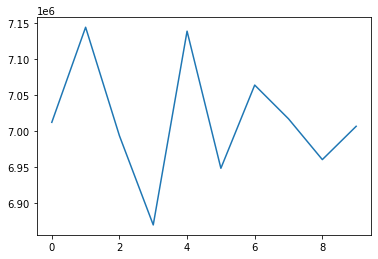

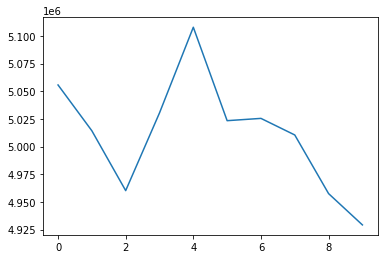

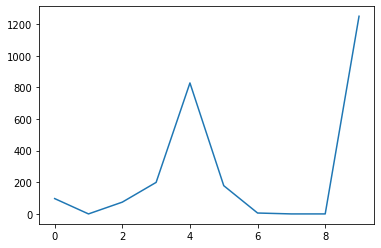

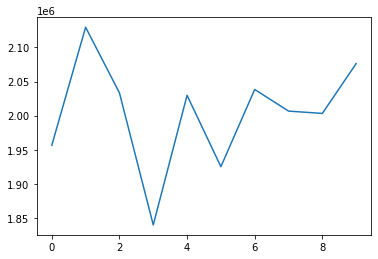

In [12]:
agent_params = {
    'gamma': 0.99,
    'epsilon': 0.1,
    'lr': 0.0001,
    'batch_size': 64,
    'eps_min': 0.1,
    'eps_dec': 0.001,
    # Every 'replace' timestep we replace the network and the target network
    # In the paper found online, it replaces every 2 episodes, try it
    'replace': 24,
    'min_action': -5,
    # 'min_sat_action': -20,
    'max_action': 5,
    # 'max_sat_action': 20,
    # Need to keep distinct action values of [-20, 20], we round 1 decimal place
    'num_actions': 40,
    'mem_size': 240,
#     'discrete_sat_actions': 66,
    'seed': 42
}
    
    
obs = model.reset()
state, AHUs = vectorise(obs, dist_names, obs_history)
agent_AHU1 = DQNAgent({**agent_params, 'input_dims': (len(state) + len(AHUs[0]),)}, DQN_Network)
agent_AHU2 = DQNAgent({**agent_params, 'input_dims': (len(state) + len(AHUs[1]),)}, DQN_Network)
agent_AHU3 = DQNAgent({**agent_params, 'input_dims': (len(state) + len(AHUs[2]),)}, DQN_Network)

num_episode = 10
HVAC = np.zeros(num_episode)
fans = np.zeros(num_episode)
heating = np.zeros(num_episode)
cooling = np.zeros(num_episode)
# obs, actions, agent = run_episode(model, [agent_AHU1, agent_AHU2,agent_AHU3],
#                                   dist_names, obs_history)
for i in tqdm(range(num_episode)):
    obs, actions, agent = run_episode(model, [agent_AHU1, agent_AHU2,agent_AHU3], dist_names, obs_history)
    obs_history = pd.DataFrame(obs)
    obs_history.index = obs_history['time']
    obs_history.drop(columns=['time'], inplace=True)
    HVAC[i] = np.sum(obs_history["HVAC Cost"]) / 4000
    fans[i] = np.sum(obs_history["Fans Cost"]) / 4000
    heating[i] = np.sum(obs_history["Heating Cost"]) / 4000
    cooling[i] = np.sum(obs_history["Cooling Cost"]) / 4000
    
plt.plot(HVAC)
plt.show()
plt.plot(fans)
plt.show()
plt.plot(heating)
plt.show()
plt.plot(cooling)
plt.show()

In [13]:
HVAC

array([7012286.71700791, 7143873.54701878, 6993707.99128991,
       6870323.6037762 , 7138429.2594757 , 6948702.69620419,
       7063843.61924652, 7017129.99665235, 6960722.10075622,
       7006794.21425257])

In [15]:
dqn = pd.DataFrame(obs)
# dqn['time'] = dqn['time'].mask(dqn['time'].dt.year > 1,
#                              dqn['time'] + pd.offsets.DateOffset(year=1991))
dqn.index = dqn['time']
dqn.drop(columns=['time'], inplace=True)
dqn.head()

,timestep,temperature,occupancy,terminate,reward,PMV,PPD,Lights,Fans Cost,Cooling Cost,...,System Node Setpoint Temperature_VAV_2 SUPPLY EQUIPMENT OUTLET NODE,System Node Setpoint Temperature_VAV_3 SUPPLY EQUIPMENT OUTLET NODE,AHU1 MA Temp.,AHU2 MA Temp.,AHU3 MA Temp.,Wind Speed,Wind Direction,Diffuse Solar Rad.,Direct Solar Rad.,HVAC Power
time,,,,,,,,,,,,,,,,,,,,,
1991-07-01 00:15:00,0,"{'Core_bottom': 24.637464688560218, 'Core_mid'...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...",False,NaN,"{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...","{'Core_bottom': 476228.40807524405, 'Core_mid'...",0.0,0.0,...,12.800000,12.800000,24.622754,25.311911,22.989326,3.250,347.5,0.0,0.0,8.440094
1991-07-01 00:30:00,1,"{'Core_bottom': 24.632549236026296, 'Core_mid'...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...",False,-983689.186327,"{'Core_bottom': -0.23674295502753231, 'Core_mi...","{'Core_bottom': 6.163033888512302, 'Core_mid':...","{'Core_bottom': 476228.40807524405, 'Core_mid'...",0.0,0.0,...,12.800000,12.800000,24.615844,25.305343,22.938026,3.400,15.0,0.0,0.0,8.440094
1991-07-01 00:45:00,2,"{'Core_bottom': 24.627573422207853, 'Core_mid'...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...",False,-983689.186327,"{'Core_bottom': -0.23754809813081051, 'Core_mi...","{'Core_bottom': 6.1709768620456344, 'Core_mid'...","{'Core_bottom': 476228.40807524405, 'Core_mid'...",0.0,0.0,...,29.011911,26.989326,24.607828,25.297574,22.882158,3.550,42.5,0.0,0.0,8.440094
1991-07-01 01:00:00,3,"{'Core_bottom': 24.622486445356554, 'Core_mid'...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...",False,-983689.186327,"{'Core_bottom': -0.23838046384231054, 'Core_mi...","{'Core_bottom': 6.179217004316627, 'Core_mid':...","{'Core_bottom': 476228.40807524405, 'Core_mid'...",0.0,0.0,...,29.005343,24.838026,24.599430,25.289313,22.827864,3.700,70.0,0.0,0.0,8.440094
1991-07-01 01:15:00,4,"{'Core_bottom': 24.61727913492755, 'Core_mid':...","{'Core_bottom': 0.0, 'Core_mid': 0.0, 'Core_to...",False,-983689.186327,"{'Core_bottom': -0.23924888109050627, 'Core_mi...","{'Core_bottom': 6.1878450497201385, 'Core_mid'...","{'Core_bottom': 476228.40807524405, 'Core_mid'...",0.0,0.0,...,28.997574,25.782158,24.590807,25.280680,22.774796,3.725,75.0,0.0,0.0,8.440094


In [56]:
results_dir = 'simulation_results'
dqn.to_pickle(os.path.join(results_dir, "DQN-500.pkl"))

np.savetxt("DQN500HVACs.csv", g, delimiter=",")

In [8]:
dqn[["System Node Setpoint Temperature_VAV_1 SUPPLY EQUIPMENT OUTLET NODE",
    "System Node Setpoint Temperature_VAV_2 SUPPLY EQUIPMENT OUTLET NODE",
    "System Node Setpoint Temperature_VAV_3 SUPPLY EQUIPMENT OUTLET NODE"]]

,System Node Setpoint Temperature_VAV_1 SUPPLY EQUIPMENT OUTLET NODE,System Node Setpoint Temperature_VAV_2 SUPPLY EQUIPMENT OUTLET NODE,System Node Setpoint Temperature_VAV_3 SUPPLY EQUIPMENT OUTLET NODE
time,,,
1991-07-01 00:15:00,12.800000,12.800000,12.800000
1991-07-01 00:30:00,12.800000,12.800000,12.800000
1991-07-01 00:45:00,27.822754,20.311911,20.289326
1991-07-01 01:00:00,27.015844,24.405343,19.738026
1991-07-01 01:15:00,24.207828,24.397574,19.682158
...,...,...,...
1991-07-14 23:00:00,31.268481,31.317164,22.218751
1991-07-14 23:15:00,31.249574,31.450230,19.243518
1991-07-14 23:30:00,22.230771,30.398800,16.572011


## Compare Statistics and Plot

In [19]:
baseline = pd.read_pickle(dataset_name)

In [17]:
def get_avg_PPD(df, working_time):
    # Get PPD only when in working hours and zone is occupied
    means = []
    for i in range(len(df)):
        curr = df.iloc[i]
        PPDs = []
        if curr.name.hour in working_time:
            for zone in curr['PPD'].keys():
                if curr['occupancy'][zone] > 0:
                    PPDs.append(curr['PPD'][zone])
        if len(PPDs) == 0:
            mean = 0
        else:
            mean = np.mean(PPDs)
        means.append(mean)
    return np.mean(means)


def getStatics(df, working_time):
    meanPPD = get_avg_PPD(df, working_time)
    print("Average PPD = ", meanPPD)
    
    fans_cost = np.sum(df["Fans Cost"]) * 900 / 1000 / 3600 # Unit in kWh
    print("Energy Consumed by the Fans in HVAC System = {:.2f}kWh".format(fans_cost))
    
    cooling_cost = np.sum(df["Cooling Cost"]) * 900 / 1000 / 3600 # Unit in kWh
    print("Energy Consumed by the Cooling in HVAC System = {:.2f}kWh".format(cooling_cost))
    
    heating_cost = np.sum(df["Heating Cost"]) * 900 / 1000 / 3600 # Unit in kWh
    print("Energy Consumed by the Heating in HVAC System = {:.2f}kWh".format(heating_cost))
    
    HVACEnergy = np.sum(df["HVAC Cost"]) * 900 / 1000 / 3600 # Unit in kWh
    print("Energy Consumed by the HVAC System = {:.2f}kWh".format(HVACEnergy))

# getStatics(df)

# HVACPower = np.sum(pd.DataFrame(obs)["HVAC Power"])
# HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
# print("Energy Consumed by the HVAC System = {:.2f}kWh".format(HVACEnergy))

# HVACPower = np.sum(obs_history["HVAC Power"])
# HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
# print("Energy Consumed by the HVAC System = {:.2f}kWh".format(HVACEnergy))

In [20]:
working_time = range(8, 17)
print("**EnergyPlus Baseline**")
getStatics(baseline, working_time)
print("**DQN**")
getStatics(dqn, working_time)

**EnergyPlus Baseline**
Average PPD =  2.859272185684426
Energy Consumed by the Fans in HVAC System = 715232.17kWh
Energy Consumed by the Cooling in HVAC System = 6638966.79kWh
Energy Consumed by the Heating in HVAC System = 14221.74kWh
Energy Consumed by the HVAC System = 7368420.71kWh
**DQN**
Average PPD =  10.101716407663005
Energy Consumed by the Fans in HVAC System = 4929262.43kWh
Energy Consumed by the Cooling in HVAC System = 2076282.36kWh
Energy Consumed by the Heating in HVAC System = 1249.43kWh
Energy Consumed by the HVAC System = 7006794.21kWh
